# Inference and Validation

Now that you have trained a network, you can use it for making predictions. This is typically called **inference**, a term borrowed from statistics. However, neural networks have a tendency to perform *too well* on the training data and aren't able to generalize to data that it hasn't seen before. This is called **overfitting** and it impairs inference performance. To test for overfitting while training, we measure the performance on data not in the training set called the **validation** set. We avoid overfitting through regularization such as dropout while monitoring the validation performance during training. In this notebook, this will be shown in PyTorch.

Let's start by loading the dataset through torchvision. This time we will be taking advantage of the test set which we can get by setting `train=False` here:

```python
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
```

The test set contains images just like the training set. Typically you will see 10-20% of the original dataset held out for testing and validation with the rest being used for training.

In [1]:
import torch
from torchvision import datasets, transforms

In [3]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True,
                                 train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True,
                                train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Here let's create a model, using the solution from the instructor for part 4.

In [4]:
from torch import nn, optim
import torch.nn.functional as F

In [5]:
class Classifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(784, 256)
    self.fc2 = nn.Linear(256, 128)
    self.fc3 = nn.Linear(128, 64)
    self.fc4 = nn.Linear(64, 10)

  def forward(self, x):
    # Make sure input tensor is flattened
    x = x.view(x.shape[0], -1)

    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.log_softmax(self.fc4(x), dim=1)

    return x

The goal of validation is to measure the model's performance on data that isn't part of the training set. Performance here is up to the developer to define. Typically this is just accuracy, the percentage of classes the network predicted correctly. Other options are [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall#Definition_(classification_context)) and top-5 error rate. We will focus on accuracy here. We will do a forward pass with one batch from the test set.

In [6]:
model = Classifier()

images, labels = next(iter(trainloader))
# Get the class probabilities
ps = torch.exp(model(images))

# Make sure the shape is appropriate, we should get 10 class probabilities for 
# 64 examples
print(ps.shape)

torch.Size([64, 10])


With the probabilities, we can get the most likely class using the `ps.topk` method. This returns the $k$ highest values. Since we just want the most likely class, we can use `ps.topk(1)`. This returns a tuple of the top-$k$ values and the top-$k$ indices. If the highest value is the fifth element, we will get back 4 as the index.

In [7]:
top_p, top_class = ps.topk(1, dim=1)
# Look at the most likely classes for hte first 10 examples
print(top_class[:10,:])

tensor([[7],
        [6],
        [7],
        [7],
        [7],
        [9],
        [6],
        [0],
        [7],
        [0]])


Now we can check if the predicted classes match the labels. This is simple to do by equating `top_class` and `labels`, but we have to be careful of the shapes. Here `top_class` is a 2D tensor with shape `(64, 1)` while `labels` is 1D with shape `(64)`. If we do

```python
equals = top_class == labels
```

`equals` will have shape `(64, 64)`, try it yourself... What it is doing is comparing the one element in each row of `top_class` with each element in `labels` which returns 64 True/False boolean values for each row.

In [8]:
top_class == labels

tensor([[False, False, False,  ..., False, False,  True],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False,  True],
        ...,
        [False, False, False,  ..., False, False,  True],
        [False, False, False,  ..., False, False,  True],
        [False, False, False,  ..., False, False,  True]])

In [12]:
# Show how this works for a simple example
torch.Tensor([1]) == torch.Tensor([[1,2,3,4,5,6,7,8,10]])

tensor([[ True, False, False, False, False, False, False, False, False]])

In [13]:
equals = top_class == labels.view(*top_class.shape)

Now we need to calculate the percentage of correct predictions. `equals` has binary values, either 0 or 1. This means that if we just sum up all the values and divide by the number of values, we get the percentage of correct predictions. This is the same operation as taking the mean, so we can get the accuracy with a call to `torch.mean`. If only it was that simple. If you try `torch.mean(equals)`, you will get an error

```
RuntimeError: mean is not implemented for type torch.ByteTensor
```

In [14]:
torch.mean(equals)

RuntimeError: ignored

This happens because `equals` has type `torch.ByteTensor` but `torch.mean` is not implemented for tensors with that type. So we will need to convert `equals` to a float tensor. Note that when we take `torch.mean` it returns a scalar tensor, to get the actual value as a float we will need to do `accuracy.item()`.

In [15]:
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f'Accuracy: {accuracy.item()*100}%')

Accuracy: 10.9375%


In [19]:
equals.type(torch.FloatTensor)[0]

tensor([0.])

The network is untrained so it is making random guesses and we should see an accuracy around 10%. Now let's train our network and include our validation pass so we can measure how well the network is performing on the test set. Since we are not updating our parameters in the validation pass, we can speed up our code by turning off gradients using `torch.no_grad()`:

```python
# turn off gradients
with torch.no_grad():
  # validation pass here
  for images, labels in testloaderL
    ...
```

>**Exercise:** Implement the validation looop below and print out the total accuracy after the loop. You should be able to get an accuracy above 80%.

In [23]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
  running_loss = 0
  for images, labels in trainloader:

    optimizer.zero_grad()
    log_ps = model(images)
    loss = criterion(log_ps, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  else: # after for-loop above completes, execute this code below
    test_loss = 0
    accuracy = 0

    ## TODO: Implement the validation pass and print out the validation accuracy
    with torch.no_grad():
      for test_images, test_labels in testloader:
        log_ps = model(test_images)
        test_loss += criterion(log_ps, test_labels)

        ps = torch.exp(log_ps)
        _, top_class = ps.topk(1, dim=1)
        equals = top_class == test_labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))

    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))

    print("Epoch: {}/{}.. ".format(e+1, epochs),
          "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
          "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
          "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/30..  Training Loss: 0.521..  Test Loss: 0.498..  Test Accuracy: 0.820
Epoch: 2/30..  Training Loss: 0.396..  Test Loss: 0.392..  Test Accuracy: 0.859
Epoch: 3/30..  Training Loss: 0.356..  Test Loss: 0.401..  Test Accuracy: 0.853
Epoch: 4/30..  Training Loss: 0.334..  Test Loss: 0.380..  Test Accuracy: 0.865
Epoch: 5/30..  Training Loss: 0.314..  Test Loss: 0.383..  Test Accuracy: 0.859
Epoch: 6/30..  Training Loss: 0.302..  Test Loss: 0.392..  Test Accuracy: 0.865
Epoch: 7/30..  Training Loss: 0.289..  Test Loss: 0.389..  Test Accuracy: 0.864
Epoch: 8/30..  Training Loss: 0.281..  Test Loss: 0.378..  Test Accuracy: 0.869
Epoch: 9/30..  Training Loss: 0.276..  Test Loss: 0.364..  Test Accuracy: 0.874
Epoch: 10/30..  Training Loss: 0.265..  Test Loss: 0.408..  Test Accuracy: 0.866
Epoch: 11/30..  Training Loss: 0.256..  Test Loss: 0.364..  Test Accuracy: 0.874
Epoch: 12/30..  Training Loss: 0.252..  Test Loss: 0.356..  Test Accuracy: 0.881
Epoch: 13/30..  Training Loss: 0.249.

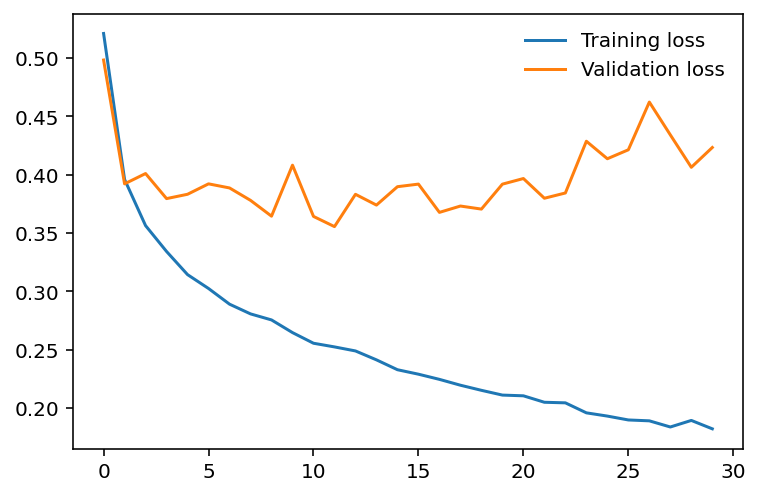

In [24]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)